OrsaEvent @ 123.456
  Multiplicity: 42
  NPE: 100.0 +5.0 -5.0
  Energy: 2.5 +0.1 -0.1
  Position (x,y,z): UncertainValue{Float64}[1.0 +0.1 -0.1, 2.0 +0.2 -0.2, 3.0 +0.1 -0.1]



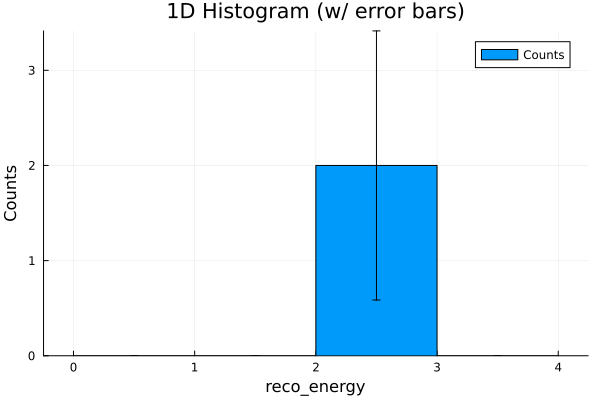

In [15]:
using OrsaFitter
using OrsaFitter.Types
using OrsaFitter.EventModule
using OrsaFitter.HistogramModule
using Plots

# Create uncertain values
x = UncertainValue(1.0, 0.1)
y = UncertainValue(2.0, 0.2)
z = UncertainValue(3.0, 0.1)
npe = UncertainValue(100.0, 5.0)
energy = UncertainValue(2.5, 0.1)

# Create one event
evt = Event_from_cartesian(123.456, x, y, z, 42, npe, energy)

# Print and plot
println(evt)
plot_event_position(evt)

# Create a 1D histogram in energy
edges = ([0.0, 1.0, 2.0, 3.0, 4.0],)  # tuple with one vector
h = HistogramND(edges, [:reco_energy])

fill_histogram!(h, [evt, evt])

# Plot histogram
plot_histogram(h, with_errorbars = true)


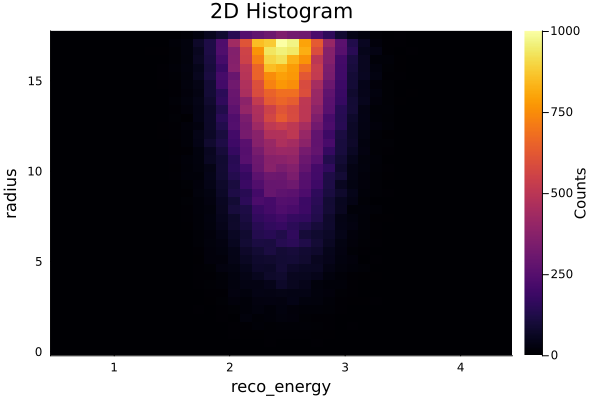

In [16]:
using OrsaFitter
using OrsaFitter.Types
using OrsaFitter.EventModule
using OrsaFitter.HistogramModule
using StaticArrays
using Random
using Distributions
using Plots

# Set seed for reproducibility
Random.seed!(1234)

# Simulation parameters
N = 100_000
radius = 17.7
μ_E = 2.5
σ_E = 0.3
gauss_energy = Normal(μ_E, σ_E)

# Create events
events = OrsaEvent[]
for _ in 1:N
    # Uniform position in sphere
    u = rand()
    costheta = rand(-1.0:0.0001:1.0)
    theta = acos(costheta)
    phi = rand() * 2π
    r = radius * u^(1/3)

    x_val = r * sin(theta) * cos(phi)
    y_val = r * sin(theta) * sin(phi)
    z_val = r * cos(theta)

    x = UncertainValue(x_val, 0.0)
    y = UncertainValue(y_val, 0.0)
    z = UncertainValue(z_val, 0.0)

    # Energy from Gaussian
    e_val = rand(gauss_energy)
    energy = UncertainValue(e_val, 0.1)

    npe = UncertainValue(100.0, 5.0)  # dummy

    push!(events, Event_from_cartesian(0.0, x, y, z, 1, npe, energy))
end

# Wrap in EventCollection
collection = OrsaEventCollection(events, CPU())

# Create 2D histogram: Energy vs Radius
edges_energy = range(0.5, 4.5; length=40) |> collect
edges_radius = range(0.0, 18.0; length=40) |> collect
h2d = HistogramND((edges_energy, edges_radius), [:reco_energy, :radius])

# to_histogram(events, )
fill_histogram!(h2d, collection)

# # Show plot
plot_histogram(h2d)


--- Generating 1e+06 Events ---
  1.146585 seconds (20.00 M allocations: 1.311 GiB, 30.42% gc time)


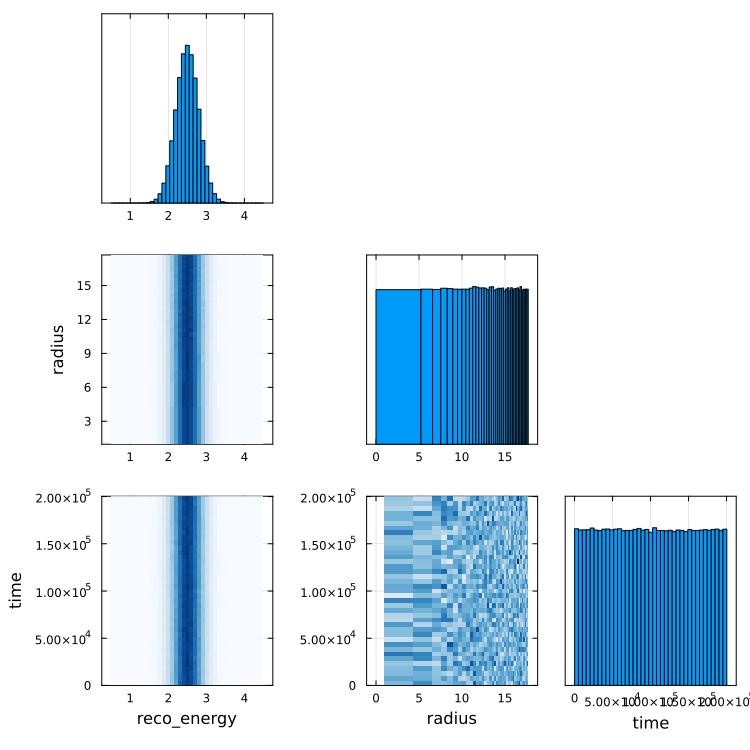

In [17]:
using OrsaFitter
using OrsaFitter.Types
using OrsaFitter.EventModule
using OrsaFitter.HistogramModule
using Random
using Distributions
using StaticArrays
using Plots
using Printf

# Seed for reproducibility
Random.seed!(123)

# Simulation settings
N = 1_000_000
radius = 17.7
μ_E, σ_E = 2.5, 0.3
gauss_E = Normal(μ_E, σ_E)

println("--- Generating $(@sprintf "%.0e" N) Events ---")

const σ_energy = 0.1
const σ_npe = 5.0
const npe_val = 100.0
const reco_mult = 1

tau = 1 / 5  # 5 Hz
exp_dist = Exponential(tau)

# Cumulative sum of N exponential samples
timestamps = cumsum(rand(exp_dist, N))


σ0 = UncertainValue(0.0, 0.0)  # cached to reuse
σ_npe_val = UncertainValue(npe_val, σ_npe)

events = @time begin
    local_events = Vector{OrsaEvent{Float64}}(undef, N)
    @inbounds for i in 1:N
        u = rand()
        θ = acos(rand(-1.0:0.0001:1.0))
        ϕ = rand() * 2π
        r = radius * cbrt(u)

        sinθ = sin(θ)
        x = r * sinθ * cos(ϕ)
        y = r * sinθ * sin(ϕ)
        z = r * cos(θ)

        E = rand(gauss_E)
        ts = timestamps[i]

        local_events[i] = Event_from_cartesian(
            ts,
            UncertainValue(x, 0.0),
            UncertainValue(y, 0.0),
            UncertainValue(z, 0.0),
            reco_mult,
            σ_npe_val,
            UncertainValue(E, σ_energy),
        )
    end
    local_events
end


# Define bins
edges_energy = collect(range(0.5, 4.5; length=40))
edges_radius = cbrt.(range(0.0, radius^3; length=40))
edges_time = range(0.0, stop=maximum(timestamps), length=40)

# Fill 3D histogram
h3d = to_histogram(events;
                   dims=[:reco_energy, :radius, :time],
                   edges=(edges_energy, edges_radius, collect(edges_time)),
                   threaded=true)

# Plot corner
plot_corner(h3d)